In [38]:
import re
import pandas as pd
import numpy as np
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

In [25]:
# load digits dataset

digits = datasets.load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [26]:
digits.target_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [28]:
print("label : ", digits.target[0])
digits.images[0]

label :  0


array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

### Training & Visualizing

In [29]:
x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5)

In [32]:
model = RandomForestClassifier(max_depth=2, n_estimators=7)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
def clean_data(graph_val):
    """removes gini impurity field from the tree to generate clean graphs"""
    return re.sub(r"gini = (.*)<br/>s", "s", graph_val)

In [39]:
def generate_graph(rf, tree_index=0, height=0, width=0):
    """decision tree graphs"""
    dot_data = StringIO()
    export_graphviz(rf.estimators_[tree_index], out_file=dot_data, filled=True, rounded=True, special_characters=True)
    graph_val = clean_data(dot_data.getvalue())
    graph = pydotplus.graph_from_dot_data(graph_val)
    print("Decision Tree {} :".format(tree_index))
    if height > 0 and width > 0:
        display(Image(graph.create_png(), height=height, width=width))
    else:
        display(Image(graph.create_png()))

Decision Tree 0 :


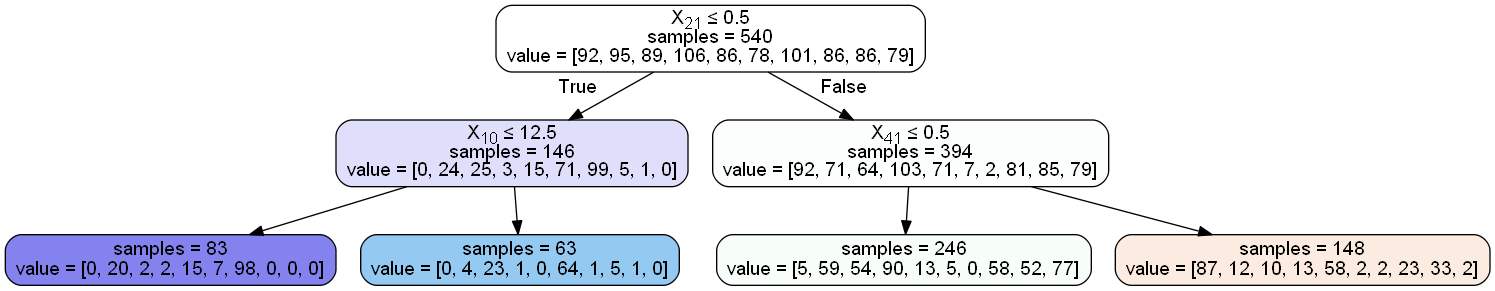

Decision Tree 1 :


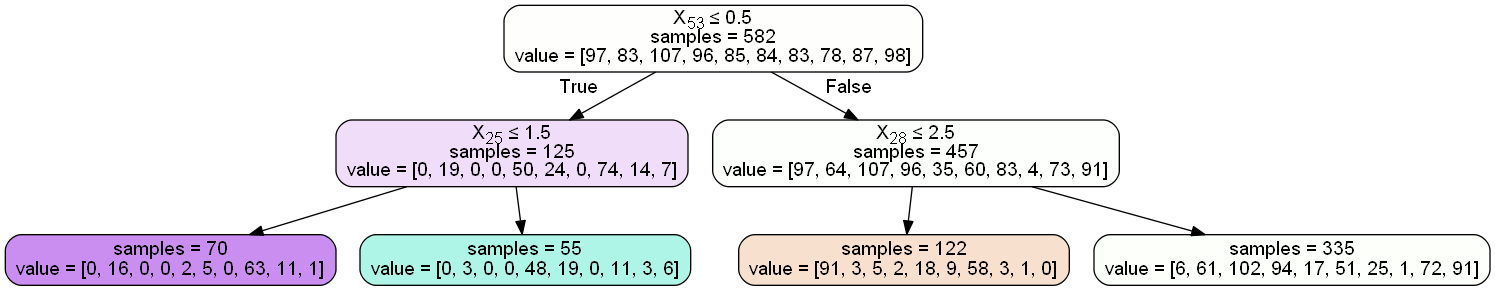

Decision Tree 2 :


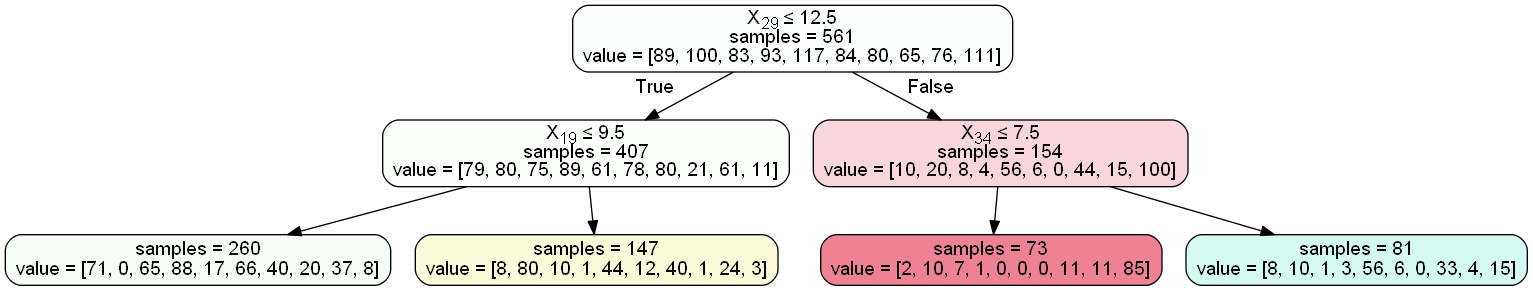

In [40]:
for dt_num in range(3):
    generate_graph(model, dt_num)

### Error Function

In [48]:
model = RandomForestClassifier(max_depth=8, n_estimators=100)
model = model.fit(x_train, y_train)

In [49]:
def predict_category(rf, sample):
    """generates predictions of each decision tree along with overall prediction"""
    pred_list = []
    for child in rf.estimators_:
        pred_list.append(child.predict(sample))
    dt_pred = np.array(pred_list, dtype=int).T
    final_pred = np.array(rf.predict(sample), dtype=int).reshape(len(sample), 1)
    return dt_pred, final_pred

In [50]:
labels = np.array([3, 5, 8])
rev_lookup = {labels[x]:x for x in range(3)}

pred, pred_category = predict_category(model, x_test)

In [63]:
choose = y_test * 0
for i in range(3):
    choose += (1 * (y_test == labels[i]))

pred_3 = pred[choose > 0, :]
y_test_3 = np.array([rev_lookup[x] for x in y_test[choose > 0]])

p = np.zeros([pred_3.shape[0], 3])
for i in range(3):
    p[:, i] = np.sum(pred_3 == labels[i], axis=1)

highest = np.argmax(p, axis=1)
mistakes = highest != y_test_3

print("counter\t index\t [%3d %4d %4d ]   prediction true" % (labels[0], labels[1], labels[2]))
print("=" * 55)

j = 0
for i in range(len(y_test_3)):
    if mistakes[i]:
        j += 1
        print(j,'\t',i,'\t [%3d %4d %4d ] \t' % (p[i, 0], p[i, 1], p[i, 2]), labels[highest[i]], '\t', labels[y_test_3[i]])

counter	 index	 [  3    5    8 ]   prediction true
1 	 115 	 [ 16   20    5 ] 	 5 	 3
2 	 263 	 [ 28   32    3 ] 	 5 	 3


### Prediction simplex

* Scores of **2** labels can be represented as a distribution over the line.
* Scores of **3** labels can be represented as points in a triangle.
* Scores of **4** or more labels is really hard to visualize.

### Triangular Simplex

In [64]:
def compute_points(p1, p2, p3, A, B):
    """returns co-ordinates of a point to plot on the simplex"""
    return 1.0 * (p1*A[0] + p2*A[1] + p3*A[2]), 1.0 * (p1*B[0] + p2*B[1] + p2*B[2])

In [65]:
def get_predictions(p1, p2, p3, label, A, B):
    """given the probablities of each categories, generate a set of points"""
    x_list_0, x_list_1, x_list_2 = [], [], []
    y_list_0, y_list_1, y_list_2 = [], [], []
    pred_list = []
    for i in range(len(label)):
        x, y = compute_points(p1[i], p2[i], p3[i], A, B)
        if p1[i] > p2[i] and p1[i] > p3[i]:
            x_list_0.append(x)
            y_list_0.append(y)
        elif p2[i] > p1[i] and p2[i] > p3[i]:
            x_list_1.append(x)
            y_list_1.append(y)
        elif p3[i] > p2[i] and p3[i] > p1[i]:
            x_list_2.append(x)
            y_list_2.append(y)
    return x_list_0, y_list_0, x_list_1, y_list_1, x_list_2, y_list_2

In [77]:
def generate_simplex(p, true, mistakes, labels, _figsize=(10, 8)):
    """generate scatter of votes from random forest inside of a simplex"""
    A = [0, 1, 0.5]
    B = [0, 0, 0.87]
    fig = plt.figure(figsize=_figsize)
    ax = fig.add_subplot(111)
    plt.plot(A + A[0:1], B + B[0:1])
    size = np.ones(true.shape)
    size[mistakes] = 20

    # compute the locations of the points
    A = np.array(A)
    B = np.array(B)
    X = np.dot(p, A)
    Y = np.dot(p, B)
    rgb = ["r", "g", "b"]
    colors = [rgb[x] for x in true]
    plt.scatter(X, Y, c=colors, s=size)

    # draw boundaries
    corner = np.array([1, 0, 0])
    margin = np.array([[0.5, 0.5, 0], [1.0/3, 1.0/3, 1.0/3], [0.5, 0, 0.5]])
    for alpha in np.arange(0.0, 1.1, 0.2):
        for rotate in range(3):
            boundary = alpha * margin + (1 - alpha) * corner
            boundary = np.roll(boundary, rotate, axis=1)
            color = "g:"
            if alpha == 1:
                color = "k:"
            plt.plot(np.dot(boundary, A), np.dot(boundary, B), color)

    plt.text(A[0] - 0.05, B[0], str(labels[0]), fontsize=20, bbox=dict(facecolor='r', alpha=0.2))
    plt.text(A[1] + 0.02, B[1], str(labels[1]), fontsize=20, bbox=dict(facecolor='g', alpha=0.2))
    plt.text(A[2] - 0.015, B[2] + 0.04, str(labels[2]), fontsize=20, bbox=dict(facecolor='b', alpha=0.2))
    plt.axis('off')
    plt.show()

In [78]:
p += np.abs(np.random.normal(0, 0.01, size=p.shape))
z = 1 / (np.sum(p, axis=1) + 0.001)
p = (p.transpose() * z).transpose()

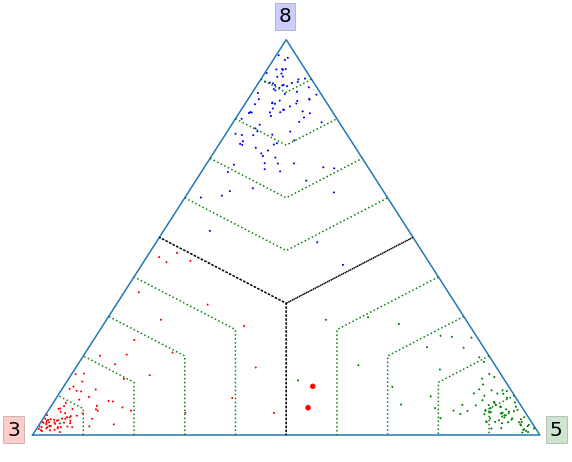

In [79]:
generate_simplex(p, y_test_3, mistakes, labels)